In [1]:
'''
!pip install pandas
!pip install torch
!pip install nltk
!pip install tqdm
!pip install seaborn
!pip install numpy
!pip install sklearn
'''

'\n!pip install pandas\n!pip install torch\n!pip install nltk\n!pip install tqdm\n!pip install seaborn\n!pip install numpy\n!pip install sklearn\n'

In [2]:
import torch
import nltk
from nltk import word_tokenize
#nltk.download('punkt')

# Скачиваем данные

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('Fake.csv')
data

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [5]:
data.subject.value_counts() * 100 / data.shape[0]

News               38.541800
politics           29.134194
left-news          18.989822
Government News     6.686257
US_News             3.334611
Middle-east         3.313317
Name: subject, dtype: float64

Ну, у нас есть дисбаланс классов

# Предобученные эмбеддинги
[Источник](https://fasttext.cc/docs/en/crawl-vectors.html)  
Вы можете взять любые word2vec подобные эмббединги. Если вы хотите использовать elmo, bert, etc сначала попробуйте с word2vec подобными эмббедингами, а потом можете перейти к более сложным моделям.  
Ниже мы сначала скачиваем, а потом распоковываем эмбеддинги.

In [6]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm

In [7]:
# потом можете добавить свою предобработку

def process_text(text):
    
    words = wordpunct_tokenize(text.lower())
    
    return words

In [8]:
word2freq = {}
lengths = []

for text in tqdm(data.text):
    
    words = process_text(text)
    
    lengths.append(len(words))
    
    for word in words:
        
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

100%|█████████████████████████████████████████████████| 23481/23481 [00:07<00:00, 3336.22it/s]


In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

C:\Users\veron\Anaconda3\envs\pt1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Распределение длин слов в текстах'}, xlabel='Длина предложения', ylabel='Доля'>

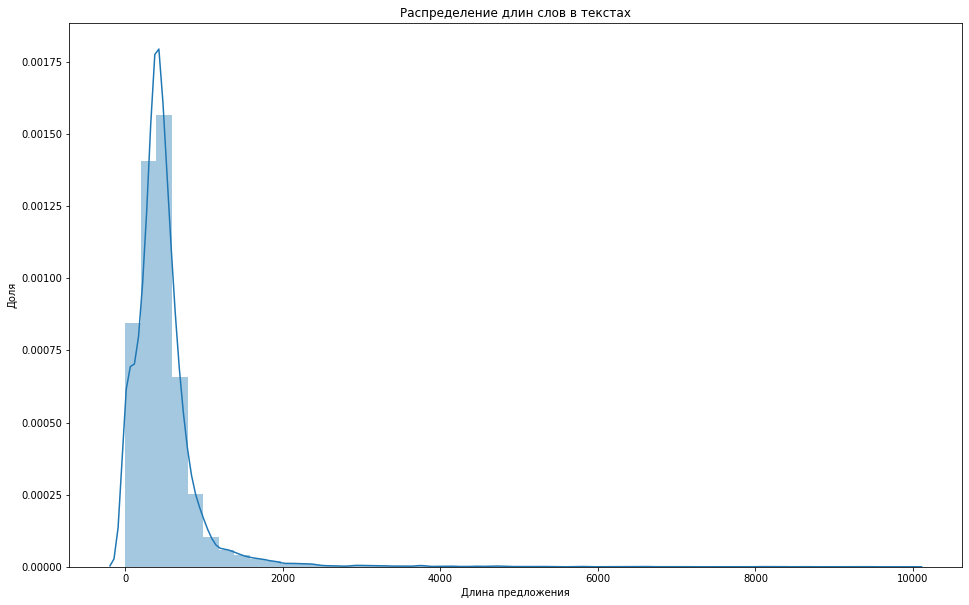

In [10]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [11]:
upper_threshold = 512 #больше карта не потянет
lower_threshold = 3

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'62.48 % наших текстов входят в промежуток от 3 до 512 слов'

In [12]:
len(word2freq)

95413

In [13]:
'{} слов, которые встречались 3 и менее раз'.format(len([word for word in word2freq if word2freq[word] <= 3]))

'54174 слов, которые встречались 3 и менее раз'

# Читаем файл с эмбеддингами
### Этот файл с 300 числами для 2 000 000 слов и он может не влезть в память
Поэтому прочитаем только те слова, которые мы знаем

In [14]:
import numpy as np
from gensim.models.keyedvectors import KeyedVectors

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [15]:
word2index = {'PAD': 0, 'UNK': 1}
vectors = []

n_words, embedding_dim = len(model.index_to_key), model.vector_size

#паддинги и уникальные
vectors.append(np.random.uniform(-0.25, 0.25, embedding_dim))
vectors.append(np.random.uniform(-0.25, 0.25, embedding_dim))
#progress_bar = tqdm(desc='Read word2vec', total=n_words)

for word in tqdm(word2freq.keys()):
    word2index[word] = len(word2index)
    if word in model:
        vectors.append(model.get_vector(word))
    else:
        vectors.append(np.random.uniform(-0.25, 0.25, embedding_dim))

vectors = torch.FloatTensor(np.array(vectors))

100%|███████████████████████████████████████████████| 95413/95413 [00:00<00:00, 129297.87it/s]


In [16]:
len(vectors)

95415

In [17]:
len(word2index)

95415

In [18]:
import torch

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Подготовим данные в DataLoader

In [20]:
from torch.utils.data import Dataset, DataLoader

In [21]:
'UNK' in word2index

True

In [22]:
data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Замапим категории в индексы

In [23]:
cat_mapper = {sub: n for n, sub in enumerate(data.subject.unique())}

In [24]:
cat_mapper

{'News': 0,
 'politics': 1,
 'Government News': 2,
 'left-news': 3,
 'US_News': 4,
 'Middle-east': 5}

In [25]:
data.subject = data.subject.map(cat_mapper)

# Читалка данных

In [26]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, sequence_length=512, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = y_data
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(x_data, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        
        # Место для вашей предобработки
        
        words = wordpunct_tokenize(text.lower())
        #words = re.findall('[a-яА-ЯеЁ]+', text.lower())
        return words
        
    def load(self, data, verbose=True):
        
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        
        for text in data_iterator:
            
            words = self.process_text(text)
            
            indexed_words = self.indexing(words)
            
            self.x_data.append(indexed_words)
    
    def indexing(self, tokenized_text):

        # здесь мы не используем токен UNK, потому что мы его специально не учили
        # становится непонятно какой же эмбеддинг присвоить неизвестному слову,
        # поэтому просто выбрасываем наши неизветсные слова
        
        return [self.word2index[word]  if word in self.word2index else self.word2index['UNK'] for word in tokenized_text]
    
    def padding(self, sequence):
        
        # Ограничить длину self.sequence_length
        # если длина меньше максимально - западить
        if len(sequence)< self.sequence_length:
          add_pad = self.sequence_length - len(sequence)
          return sequence+[self.pad_index]*add_pad
        else:
          return sequence[:self.sequence_length]
    
    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        
        y = self.y_data[idx]
        
        return x, y

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [28]:
x_train, x_validation, y_train, y_validation = train_test_split(data.text, data.subject, test_size=0.2)

train_dataset = WordData(list(x_train), list(y_train), word2index)
train_loader = DataLoader(train_dataset, batch_size=16)

validation_dataset = WordData(list(x_validation), list(y_validation), word2index)
validation_loader = DataLoader(validation_dataset, batch_size=16)

Loading data: 100%|█████████████████████████████████████| 4697/4697 [00:01<00:00, 3692.74it/s]


In [29]:
for x, y in train_loader:
    break

In [30]:
x

tensor([[  811,    77,  1794,  ...,   729,  9347,  6081],
        [  769,     2,     3,  ...,     0,     0,     0],
        [ 1549,  5953,   108,  ...,     0,     0,     0],
        ...,
        [   91,   178,    16,  ...,     0,     0,     0],
        [  627,   628, 68159,  ...,   498,    83,  5480],
        [    2,     3,   178,  ...,    46,   270, 11543]])

In [31]:
y

tensor([0, 0, 4, 1, 1, 1, 0, 4, 3, 0, 3, 3, 3, 1, 1, 0])

# Обучить нейронку

In [32]:
from math import sqrt

class model_clstm(torch.nn.Module):
    def __init__(self, matrix_w, n, conv_out=150, conv_window=[2, 3, 4],
                 dropout = 0.5,  output_dim=6, lstm_memory_dim=150,
                 dropout_locate='lstm', max_length=512): #n - количетсво категорий
        
        super().__init__()

        self.n = n
        self.embedding_dim = matrix_w.shape[1]
        #self.hidden_size = hidden_size
        self.conv_out = conv_out
        self.conv_window = conv_window
        self.max_cnn_res = max_length - max(conv_window) + 1
        self.lstm_memory_dim = lstm_memory_dim
        self.dropout = dropout
        self.dropout_locate = dropout_locate
        
        self.emb_layer = torch.nn.Embedding.from_pretrained(torch.Tensor(matrix_w))
        conv_layers = []
        for c in conv_window:
            conv_layers.append(torch.nn.Conv1d(self.embedding_dim, self.conv_out, kernel_size=(c,), padding='valid'))
        self.convs = torch.nn.ModuleList(conv_layers)

        
        self.LSTM = torch.nn.LSTM(input_size=self.conv_out * len(self.conv_window), 
                                  hidden_size=self.lstm_memory_dim,
                                  num_layers=1, batch_first=True)
        
        self.soft = torch.nn.Softmax(dim=1)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=self.lstm_memory_dim,
                                out_features=self.n)
        self.dropout = torch.nn.Dropout(p=0.5)

        
    def forward(self, x):
        
        if self.dropout_locate == 'cnn':
            x_emb = self.emb_layer(x)
        else:
            x_emb = self.dropout(self.emb_layer(x))
            
        x_emb = x_emb.transpose(1,2)
        
        cnn_results = []
        for conv in self.convs:
            cnn_res = self.relu(conv(x_emb))[:, :, :self.max_cnn_res]
            cnn_results.append(cnn_res)
            
        if len(self.conv_window) > 1:
            to_lstm = torch.cat(cnn_results, 1)
        else:
            to_lstm = cnn_res
            
        to_lstm = to_lstm.transpose(1, 2)
        _, (x, _)= self.LSTM(to_lstm)
        x.squeeze_(0)
        
        if self.dropout_locate == 'cnn':           
            x = self.dropout(x)
        logits = self.soft(self.linear(x))
        return logits

In [33]:
model_clstm = model_clstm(vectors, 6)

In [34]:
model_clstm

model_clstm(
  (emb_layer): Embedding(95415, 300)
  (convs): ModuleList(
    (0): Conv1d(300, 150, kernel_size=(2,), stride=(1,), padding=valid)
    (1): Conv1d(300, 150, kernel_size=(3,), stride=(1,), padding=valid)
    (2): Conv1d(300, 150, kernel_size=(4,), stride=(1,), padding=valid)
  )
  (LSTM): LSTM(450, 150, batch_first=True)
  (soft): Softmax(dim=1)
  (relu): ReLU()
  (linear): Linear(in_features=150, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [36]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model_clstm.parameters(), lr=0.001, weight_decay=0.001)

model_clstm = model_clstm.to(device)
criterion = criterion.to(device)

In [38]:
epochs = 10
losses = []
best_test_loss = 10.

test_accuracy = []

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_targets = []
    test_pred_class = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    model_clstm.train()
    
    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        pred = model_clstm(x)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    model_clstm.eval()
    
    for x, y in validation_loader:
        
        x = x.to(device)

        with torch.no_grad():

            pred = model_clstm(x)

            pred = pred.cpu()

            test_targets.append(y.numpy())
            test_pred_class.append(np.argmax(pred, axis=1))

            loss = criterion(pred, y)

            test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)

    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()

    accuracy = accuracy_score(test_targets, test_pred_class)

    test_accuracy.append(accuracy)
    
    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    print('Accuracy test - {:.3f}'.format(accuracy))
        
    # Early stopping:
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 1: 100%|████████████████████████| 18784/18784 [02:08<00:00, 145.89it/s, train_loss=1.55]



Losses: train - 1.565, test - 1.518
Accuracy test - 0.526


Epoch 2: 100%|████████████████████████| 18784/18784 [02:10<00:00, 143.89it/s, train_loss=1.56]



Losses: train - 1.554, test - 1.525
Accuracy test - 0.517
Early stopping


Если вы запускаете много раз колаб окна и ткдм начинает беситься, можно запустить окно ниже, ткдм обновится и все снова станет хорошо

In [ ]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)